In [ ]:
!pip install timm pytorch_lightning >/dev/null

In [ ]:
import os
from tqdm import tqdm
import torch
from torch.utils.data import Dataset
import cv2
import numpy as np
import timm
import pytorch_lightning as pl
import torch.nn.functional as F
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torch.nn as nn
import os
import random
import pandas as pd
import shutil
import seaborn as sns

torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

In [ ]:
!cp kaggle.json /root/.kaggle/kaggle.json
!kaggle datasets download -d jangedoo/utkface-new
!unzip -n utkface-new.zip >/dev/null

 97% 321M/331M [00:02<00:00, 194MB/s]
100% 331M/331M [00:02<00:00, 148MB/s]


In [ ]:
dir = '/content/crop_part1'
images = os.listdir(dir)
print('Validating Dataset...')
n_invalid = 0
n_valid = 0
for data in tqdm(images):
  data_metadata = data.split('_')
  try:
    age, gender, race = list(map(int, data_metadata[:3]))
  except:
    n_invalid += 1
    os.remove(dir + '/' + data)
  n_valid += 1
print('\n Summary')
print('----------')
print(f'Valid examples: {n_valid}')
print(f'Invalid examples: {n_invalid}')

_ = list(map(os.remove, random.sample([dir + '/' + im for im in images if int(im.split('_')[0]) < 4], int(0.7*len([im for im in images if int(im.split('_')[0]) < 4])))))
images = os.listdir(dir)

train_dir = dir + '/train'
valid_dir = dir + '/valid'
valid_fraction = 0.1
random.shuffle(images)
num_valid_images = int(len(images) * valid_fraction)

os.makedirs(train_dir, exist_ok=True)
os.makedirs(valid_dir, exist_ok=True)

for filename in images[:num_valid_images]:
    src_path = os.path.join(dir, filename)
    dst_path = os.path.join(valid_dir, filename)
    shutil.move(src_path, dst_path)

for filename in images[num_valid_images:]:
    src_path = os.path.join(dir, filename)
    dst_path = os.path.join(train_dir, filename)
    shutil.move(src_path, dst_path)

Validating Dataset...


100%|██████████| 9780/9780 [00:00<00:00, 342735.46it/s]


 Summary
----------
Valid examples: 9780
Invalid examples: 2


In [ ]:
gender_dict = {
    1: 'Female',
    0: 'Male'
}
race_dict = {
    0: 'White', 
    1: 'Black',
    2: 'Asian',
    3: 'Indian',
    4: 'Others'
}

In [ ]:
im_metadata = list(map(lambda x: x.split('_'), os.listdir(dir+'/train')))
df = pd.DataFrame(im_metadata, columns = ['age', 'gender', 'race', 'image']).drop('image', axis = 1)
df['age'] = df['age'].astype(int)
df['gender'] = df['gender'].astype(int)
df['race'] = df['race'].astype(int)
df['gender'] = df['gender'].map(gender_dict)
df['race'] = df['race'].map(race_dict)

Text(0.5, 1.0, 'Race Distribution')

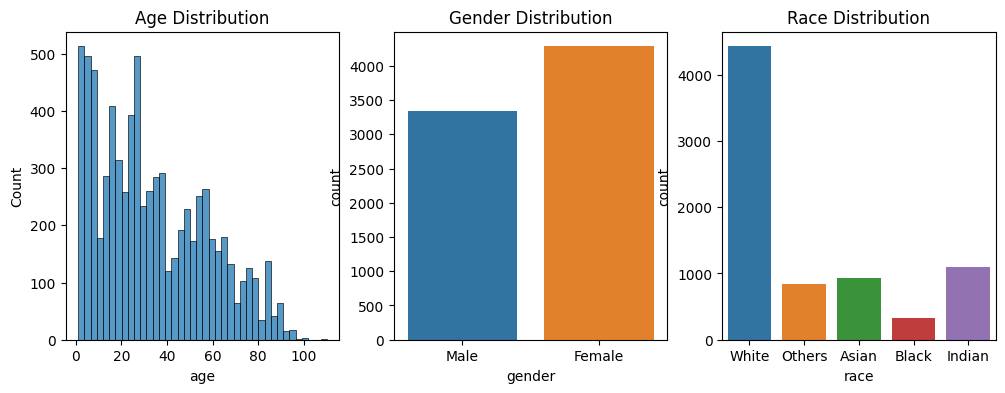

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
sns.histplot(x = 'age', data = df, bins = 40, ax = axes[0])
sns.countplot(x = 'gender', data = df, ax = axes[1])
sns.countplot(x = 'race', data = df, ax = axes[2])

axes[0].set_title('Age Distribution')
axes[1].set_title('Gender Distribution')
axes[2].set_title('Race Distribution')

In [ ]:
class AgeGenderRaceDataset(Dataset):
    
    def __init__(self, data_path):
      
      self.data = os.listdir(data_path)
      self.dir = data_path

    def __getitem__(self, index):

      image_path = self.data[index]
      data_info = self.data[index].split('_')
      
      image = cv2.imread(self.dir + '/' + image_path)
      image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
      image =  torch.from_numpy(image).permute(2, 0, 1) / 255.0
      
      age, gender, race = list(map(int, data_info[:3]))
     
      return image, torch.stack((torch.tensor(age), torch.tensor(gender), torch.tensor(race)))

    def __len__(self):
      
      return len(self.data)

In [ ]:
train_ds = AgeGenderRaceDataset('/content/crop_part1/train')
valid_ds = AgeGenderRaceDataset('/content/crop_part1/valid')

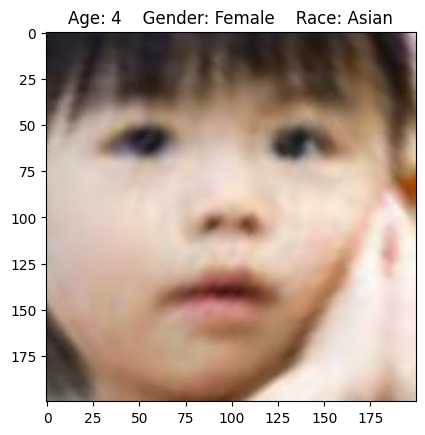

In [ ]:
sample = train_ds[31]
plt.title(f'Age: {sample[1][0].item()}    Gender: {gender_dict[sample[1][1].item()]}    Race: {race_dict[sample[1][2].item()]}')
plt.imshow(sample[0].permute(1, 2, 0))

In [ ]:
train_dl = DataLoader(train_ds, batch_size = 16, shuffle = True)
valid_dl = DataLoader(valid_ds, batch_size = 16)

In [ ]:
class CustomModelMain(nn.Module):
    def __init__(self, problem_type, n_classes):
        super().__init__()
        if problem_type == 'Classification' and n_classes == 1:
            output = nn.Sigmoid()
        elif problem_type == 'Regression' and n_classes == 1:
            output = nn.ReLU()
        elif problem_type == 'Classification' and n_classes > 1:
            output = nn.Softmax(dim = 1)
        self.conv1 = nn.Conv2d(in_channels = 3, out_channels = 32, kernel_size = 3, padding = 1)
        self.pool1 = nn.MaxPool2d(kernel_size = 2, stride = 2)
        self.conv2 = nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = 3, padding = 1)
        self.pool2 = nn.MaxPool2d(kernel_size = 2, stride = 2)
        self.conv3 = nn.Conv2d(in_channels = 64, out_channels = 64, kernel_size = 3, padding = 1)
        self.pool3 = nn.MaxPool2d(kernel_size = 2, stride = 2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(64 * 25 * 25 , 128)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p = 0.5)
        self.fc2 = nn.Linear(128, n_classes)
        self.output = output
    def forward(self, x):
        x = self.conv1(x)
        x = self.pool1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.pool2(x)
        x = self.relu(x)
        x = self.conv3(x)
        x = self.pool3(x)
        x = self.relu(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.output(x)
        return x

# Joint Models

In [ ]:
class Ultimate_Lightning(pl.LightningModule):
  def __init__(self):
    super().__init__()
    self.age_model = CustomModelMain('Regression', 1)
    self.gender_model = CustomModelMain('Classification', 1)
    self.race_model = CustomModelMain('Classification', 5)
  def forward(self, x):
    return self.age_model(x), self.gender_model(x), self.race_model(x)
  def training_step(self, batch, batch_idx):
    x, y = batch
    y_age, y_gender, y_race = y[:, 0], y[:, 1], y[:, 2]
    y_hat_age, y_hat_gender, y_hat_race = self(x)
    
    age_loss = F.mse_loss(y_hat_age, y_age.unsqueeze(-1).float())
    age_acc = torch.eq((y_hat_age > 0.5).int().to(torch.int64), y_age.unsqueeze(-1).int()).all(dim=1).sum() / len(y_age)
    
    gender_loss = F.binary_cross_entropy(y_hat_gender, y_gender.unsqueeze(-1).float())
    gender_acc = torch.eq((y_hat_gender > 0.5).int().to(torch.int64), y_gender.unsqueeze(-1).int()).all(dim=1).sum() / len(y_gender)

    y_race_oh = F.one_hot(y_race, num_classes = 5)
    race_loss = F.cross_entropy(y_hat_race.log(), y_race_oh.float())
    race_preds = y_hat_race.argmax(dim = 1)
    race_acc = torch.eq(y_race, race_preds).float().mean()
    
    total_loss = (0.001 * age_loss) + gender_loss + race_loss

    self.log('age loss', age_loss, prog_bar = True)
    self.log('gender loss', gender_loss, prog_bar = True)
    self.log('race loss', race_loss, prog_bar = True)
    self.log('gender acc', gender_acc, prog_bar = True)
    self.log('race acc', race_acc, prog_bar = True)
    self.log('total loss', total_loss, prog_bar = True)
    
    return total_loss
      
  def validation_step(self, batch, batch_idx):
    x, y = batch
    y_age, y_gender, y_race = y[:, 0], y[:, 1], y[:, 2]
    y_hat_age, y_hat_gender, y_hat_race = self(x)
    
    age_loss = F.mse_loss(y_hat_age, y_age.unsqueeze(-1).float())
    age_acc = torch.eq((y_hat_age > 0.5).int().to(torch.int64), y_age.unsqueeze(-1).int()).all(dim=1).sum() / len(y_age)
    
    gender_loss = F.binary_cross_entropy(y_hat_gender, y_gender.unsqueeze(-1).float())
    gender_acc = torch.eq((y_hat_gender > 0.5).int().to(torch.int64), y_gender.unsqueeze(-1).int()).all(dim=1).sum() / len(y_gender)

    y_race_oh = F.one_hot(y_race, num_classes = 5)
    race_loss = F.cross_entropy(y_hat_race.log(), y_race_oh.float())
    race_preds = y_hat_race.argmax(dim = 1)
    race_acc = torch.eq(y_race, race_preds).float().mean()
    
    total_loss = (0.001 * age_loss) + gender_loss + race_loss

    self.log('val age loss', age_loss, prog_bar = True)
    
    self.log('val gender acc', gender_acc, prog_bar = True)
    
    self.log('val race acc', race_acc, prog_bar = True)
    
  def configure_optimizers(self):
    return torch.optim.Adam(self.parameters(), lr=1e-4)

ultimate_trainer = pl.Trainer(max_epochs = 20, accelerator = "gpu")
ultimate_model = Ultimate_Lightning()

ultimate_trainer.fit(ultimate_model, train_dl, valid_dl)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type            | Params
-------------------------------------------------
0 | age_model    | CustomModelMain | 5.2 M 
1 | gender_model | CustomModelMain | 5.2 M 
2 | race_model   | CustomModelMain | 5.2 M 
-------------------------------------------------
15.5 M    Trainable params
0         Non-trainable params
15.5 M    Total params
62.121    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.


In [ ]:
from face_fact_models import age_lightning, gender_lightning, race_lightning
trainer = pl.Trainer(max_epochs = 25, accelerator = "gpu")
age_model = age_lightning()

trainer.fit(age_model, train_dl, valid_dl)

trainer = pl.Trainer(max_epochs = 25, accelerator = "gpu")
gender_model = gender_lightning()

trainer.fit(gender_model, train_dl, valid_dl)

trainer = pl.Trainer(max_epochs = 25, accelerator = "gpu")
race_model = race_lightning()

trainer.fit(race_model, train_dl, valid_dl)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type            | Params
------------------------------------------
0 | model | CustomModelMain | 5.2 M 
------------------------------------------
5.2 M     Trainable params
0         Non-trainable params
5.2 M     Total params
20.706    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=25` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type            | Params
------------------------------------------
0 | model | CustomModelMain | 5.2 M 
------------------------------------------
5.2 M     Trainable params
0         Non-trainable params
5.2 M     Total params
20.706    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=25` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type            | Params
------------------------------------------
0 | model | CustomModelMain | 5.2 M 
------------------------------------------
5.2 M     Trainable params
0         Non-trainable params
5.2 M     Total params
20.708    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=25` reached.


In [ ]:
torch.save(age_model.state_dict(), 'age_model.pth')
torch.save(gender_model.state_dict(), 'gender_model.pth')
torch.save(race_model.state_dict(), 'race_model.pth')

#Standalone Age Model

In [ ]:
# Validation Loss - 166
class age_lightning(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.model = CustomModelMain('Regression', 1)
    def forward(self, x):
        return self.model(x)
    def training_step(self, batch, batch_idx):
        x, y = batch
        y = y[:, 0]
        y_hat = self(x)
        loss = F.mse_loss(y_hat, y.unsqueeze(-1).float())
        acc = torch.eq((y_hat > 0.5).int().to(torch.int64), y.unsqueeze(-1).int()).all(dim=1).sum() / len(y)
        self.log('train loss', loss, prog_bar = True)
        return loss
    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_val = y[:, 0]
        y_hat = self(x)
        loss = F.mse_loss(y_hat, y_val.unsqueeze(-1).float())
        self.log('valid loss', loss, prog_bar = True)
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-4)

trainer = pl.Trainer(max_epochs = 25, accelerator = "gpu")
age_model = age_lightning()

trainer.fit(age_model, train_dl, valid_dl)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type            | Params
------------------------------------------
0 | model | CustomModelMain | 5.2 M 
------------------------------------------
5.2 M     Trainable params
0         Non-trainable params
5.2 M     Total params
20.706    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=25` reached.


#Standalone Gender Model

In [ ]:
# 88.5% Validation Accuracy
class gender_lightning(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.model = CustomModelMain('Classification', 1)
    def forward(self, x):
        return self.model(x)
    def training_step(self, batch, batch_idx):
        x, y = batch
        y = y[:, 1]
        y_hat = self(x)
        loss = F.binary_cross_entropy(y_hat, y.unsqueeze(-1).float())
        acc = torch.eq((y_hat > 0.5).int().to(torch.int64), y.unsqueeze(-1).int()).all(dim=1).sum() / len(y)
        self.log('train loss', loss, prog_bar = True)
        self.log('accuracy', acc, prog_bar = True)
        return loss
    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_val = y[:, 1]
        y_hat = self(x)
        loss = F.binary_cross_entropy_with_logits(y_hat, y_val.unsqueeze(-1).float())
        acc =  torch.eq((y_hat > 0.5).int().to(torch.int64), y_val.unsqueeze(-1).int()).all(dim=1).sum() / len(y_val)
        self.log('valid loss', loss, prog_bar = True)
        self.log('val accuracy', acc, prog_bar = True)
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-4)

trainer = pl.Trainer(max_epochs = 20, accelerator = "gpu")
gender_model = gender_lightning()
trainer.fit(gender_model, train_dl, valid_dl)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type            | Params
------------------------------------------
0 | model | CustomModelMain | 5.2 M 
------------------------------------------
5.2 M     Trainable params
0         Non-trainable params
5.2 M     Total params
20.706    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.


#Standalone Race Model

In [ ]:
# 79.0% Validation acccuracy
import torchvision.models as models
class race_lightning(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.model = CustomModelMain('Classification', 5)
    def forward(self, x):
        return self.model(x)
    def training_step(self, batch, batch_idx):
        x, y = batch
        y = y[:, 2]
        y_hat = self(x)
        y_oh = F.one_hot(y, num_classes = 5)
        loss = F.cross_entropy(y_hat.log(), y_oh.float())
        preds = y_hat.argmax(dim = 1)
        acc = torch.eq(y, preds).float().mean()
        self.log('train loss', loss, prog_bar = True)
        self.log('accuracy', acc, prog_bar = True)
        return loss
    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_val = y[:, 2]
        y_hat = self(x)
        y_oh = F.one_hot(y_val, num_classes = 5)
        loss = F.cross_entropy(y_hat, y_oh.float())
        preds = y_hat.argmax(dim = 1)
        acc = torch.eq(y_val, preds).float().mean()
        self.log('valid loss', loss, prog_bar = True)
        self.log('val accuracy', acc, prog_bar = True)
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-4)

trainer = pl.Trainer(max_epochs = 20, accelerator = "gpu")
race_model = race_lightning()
trainer.fit(race_model, train_dl, valid_dl)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type            | Params
------------------------------------------
0 | model | CustomModelMain | 5.2 M 
------------------------------------------
5.2 M     Trainable params
0         Non-trainable params
5.2 M     Total params
20.708    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.
